# Задание:
1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: [ods.ai](https://ods.ai/competitions/) и [recsyschallenge.com/2025](https://www.recsyschallenge.com/2025/) (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: [aicrowd.com](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset) и [boosters.pro](https://boosters.pro/championship/rekko_challenge/data). Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).
2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.
3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств.
4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).
5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.
# Критерии оценки:
- Разведочный анализ данных. Оценивается полнота и логика описания датасета. Полнота и логика построения отчёта, качество визуализаций. (10 баллов).
- Метод формирования рекомендаций. Оценивается полнота и логика описания выбранного метода, его обоснованность и релевантность задаче. Оценивается корректность реализации выбранного метода. (14 баллов).
- Метрики качества. Оценивается корректность выбора метрик, полнота и логика их описания, корректность реализации и интерпретации выбранных метрик. (6 баллов).


---
## 0. Импорты, скачивания

In [1]:
import json
import os.path
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

---
## 1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: [ods.ai](https://ods.ai/competitions/) и [recsyschallenge.com/2025](https://www.recsyschallenge.com/2025/) (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: [aicrowd.com](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset) и [boosters.pro](https://boosters.pro/championship/rekko_challenge/data). Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).

За основу я взял [spotify-million-playlist-dataset-challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset). Предобработку (json chunks в parquet) я сделал в файле pre.py


In [ ]:
df = pd.read_parquet("mpd.parquet")
df.head(10)

Merging slices: 100%|██████████| 1000/1000 [02:34<00:00,  6.48it/s]


In [22]:
playlists = df["playlist_id"].drop_duplicates().sample(frac=0.01, random_state=42)
df_sample = df[df["playlist_id"].isin(playlists)].reset_index(drop=True)

---
## 2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.


In [44]:
print(f"Full DF size: {len(df):,}")
print(f"DF sample size: {len(df_sample):,}")
print(f"Unique playlist count: {df_sample['playlist_id'].nunique():,}")
print(f"Unique track count: {df_sample['track_uri'].nunique():,}")
print(f"Unique artist count: {df_sample['artist_name'].nunique():,}")
print(f"Duplicates in playlists: {df_sample.duplicated(subset=["playlist_id", "track_uri"]).sum()}")

print("-" * 30)
print(f"Skips:\n{df_sample.isna().sum()}")

print("-" * 30)
q_low = df_sample["duration_ms"].quantile(0.01)
q_high = df_sample["duration_ms"].quantile(0.99)

below = (df_sample["duration_ms"] < q_low).sum()
above = (df_sample["duration_ms"] > q_high).sum()

print(f"1st percentile [below - {below}]: {q_low/1000:.1f} sec")
print(f"99th percentile [above - {above}]: {q_high/1000:.1f} sec")

df_sample.describe()

Full DF size: 33,119,074
DF sample size: 333,178
Unique playlist count: 5,000
Unique track count: 107,905
Unique artist count: 24,354
Duplicates in playlists: 4334
------------------------------
Skips:
playlist_id      0
playlist_name    0
modified_at      0
track_uri        0
track_name       0
artist_name      0
album_name       0
pos              0
duration_ms      0
dtype: int64
------------------------------
1st percentile [below - 3332]: 108.5 sec
99th percentile [above - 3330]: 463.7 sec


,playlist_id,modified_at,pos,duration_ms
count,333178.000000,3.331780e+05,333178.000000,3.331780e+05
mean,291487.244302,1.481388e+09,54.531356,2.348936e+05
std,152740.838728,3.436577e+07,48.222215,7.678724e+04
min,88.000000,1.299629e+09,0.000000,0.000000e+00
25%,170328.000000,1.467504e+09,17.000000,1.989630e+05
50%,296584.000000,1.495584e+09,40.000000,2.252050e+05
75%,422537.000000,1.507075e+09,79.000000,2.590720e+05
max,548982.000000,1.509494e+09,249.000000,7.745153e+06


In [ ]:
df_sample.sort_values(by="duration_ms", ascending=False).head(5)

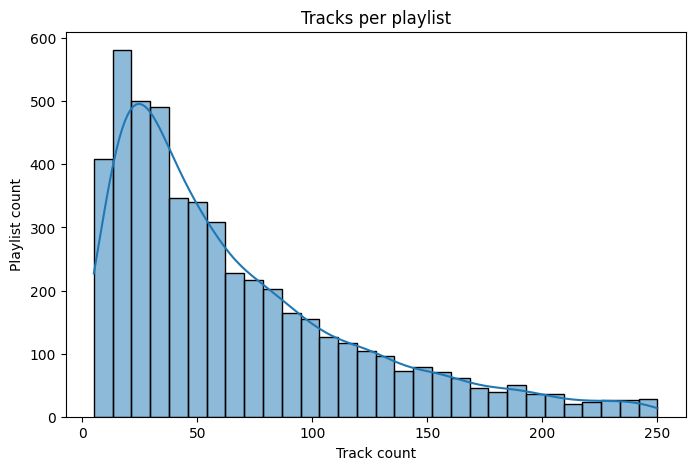

In [24]:
tracks_per_playlist = df_sample.groupby("playlist_id")["track_uri"].count()
plt.figure(figsize=(8, 5))
sns.histplot(tracks_per_playlist, bins=30, kde=True)
plt.title("Tracks per playlist")
plt.xlabel("Track count")
plt.ylabel("Playlist count")
plt.show()

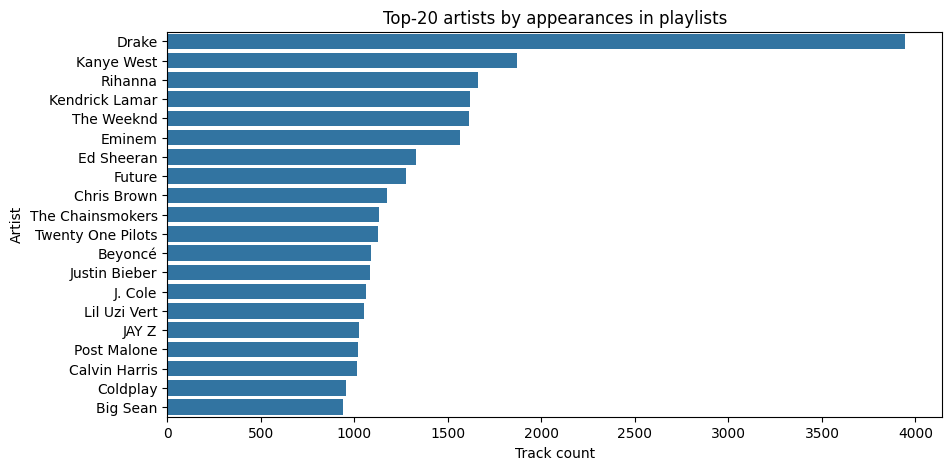

In [25]:
top_artists = df_sample["artist_name"].value_counts().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title("Top-20 artists by appearances in playlists")
plt.xlabel("Track count")
plt.ylabel("Artist")
plt.show()

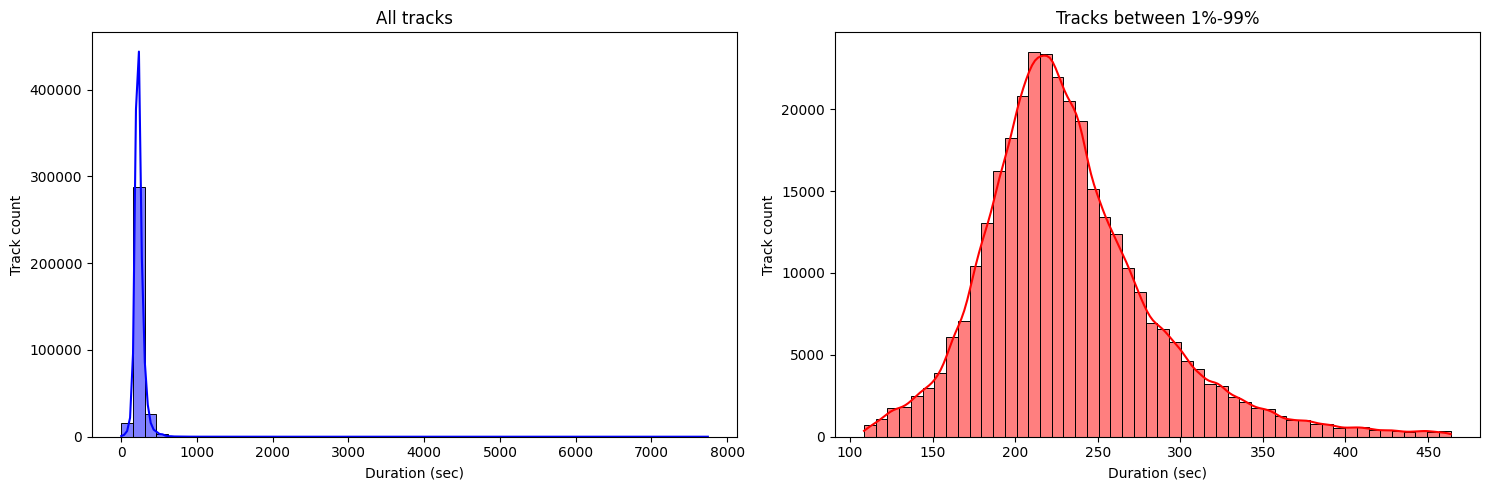

In [41]:
durations_filtered = df_sample.loc[
    (df_sample["duration_ms"] >= q_low) &
    (df_sample["duration_ms"] <= q_high),
    "duration_ms"
]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_sample["duration_ms"] / 1000, bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("All tracks")
axes[0].set_xlabel("Duration (sec)")
axes[0].set_ylabel("Track count")

sns.histplot(durations_filtered / 1000, bins=50, kde=True, ax=axes[1], color="red")
axes[1].set_title("Tracks between 1%-99%")
axes[1].set_xlabel("Duration (sec)")
axes[1].set_ylabel("Track count")

plt.tight_layout()
plt.show()

---
## 3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств.


---
## 4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).


---
## 5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.